In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import DataImport
import ProcessTrips

trips = ProcessTrips.transformTrips(DataImport.trips)
zones = DataImport.zones

Original number of rows: 4667
Number of rows after removing outliers: 4667
Number of rows after dropping NA values: 4667


In [2]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4667 entries, 0 to 5880
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   VendorID                4667 non-null   int64         
 1   tpep_pickup_datetime    4667 non-null   datetime64[ns]
 2   tpep_dropoff_datetime   4667 non-null   datetime64[ns]
 3   passenger_count         4667 non-null   int64         
 4   trip_distance           4667 non-null   float64       
 5   store_and_fwd_flag      4667 non-null   object        
 6   PULocationID            4667 non-null   int64         
 7   DOLocationID            4667 non-null   int64         
 8   payment_type            4667 non-null   int64         
 9   fare_amount             4667 non-null   float64       
 10  extra                   4667 non-null   float64       
 11  mta_tax                 4667 non-null   float64       
 12  tip_amount              4667 non-null   float64      

### Dataset preparation. <br>
- Split dataset to test and train


Split data to train and test 

In [3]:
rng = np.random.default_rng(123)

dt_index = trips.index
smpl_index = rng.choice(dt_index, size=int(np.floor(0.8 * len(dt_index))), replace=False)

dt_train = trips.loc[smpl_index].reset_index(drop=True)
dt_test = trips.drop(smpl_index)  # Drop selected indices to get the test set

print(len(dt_train))
print(len(dt_test))

3733
934


In [4]:
dt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3733 entries, 0 to 3732
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   VendorID                3733 non-null   int64         
 1   tpep_pickup_datetime    3733 non-null   datetime64[ns]
 2   tpep_dropoff_datetime   3733 non-null   datetime64[ns]
 3   passenger_count         3733 non-null   int64         
 4   trip_distance           3733 non-null   float64       
 5   store_and_fwd_flag      3733 non-null   object        
 6   PULocationID            3733 non-null   int64         
 7   DOLocationID            3733 non-null   int64         
 8   payment_type            3733 non-null   int64         
 9   fare_amount             3733 non-null   float64       
 10  extra                   3733 non-null   float64       
 11  mta_tax                 3733 non-null   float64       
 12  tip_amount              3733 non-null   float64 

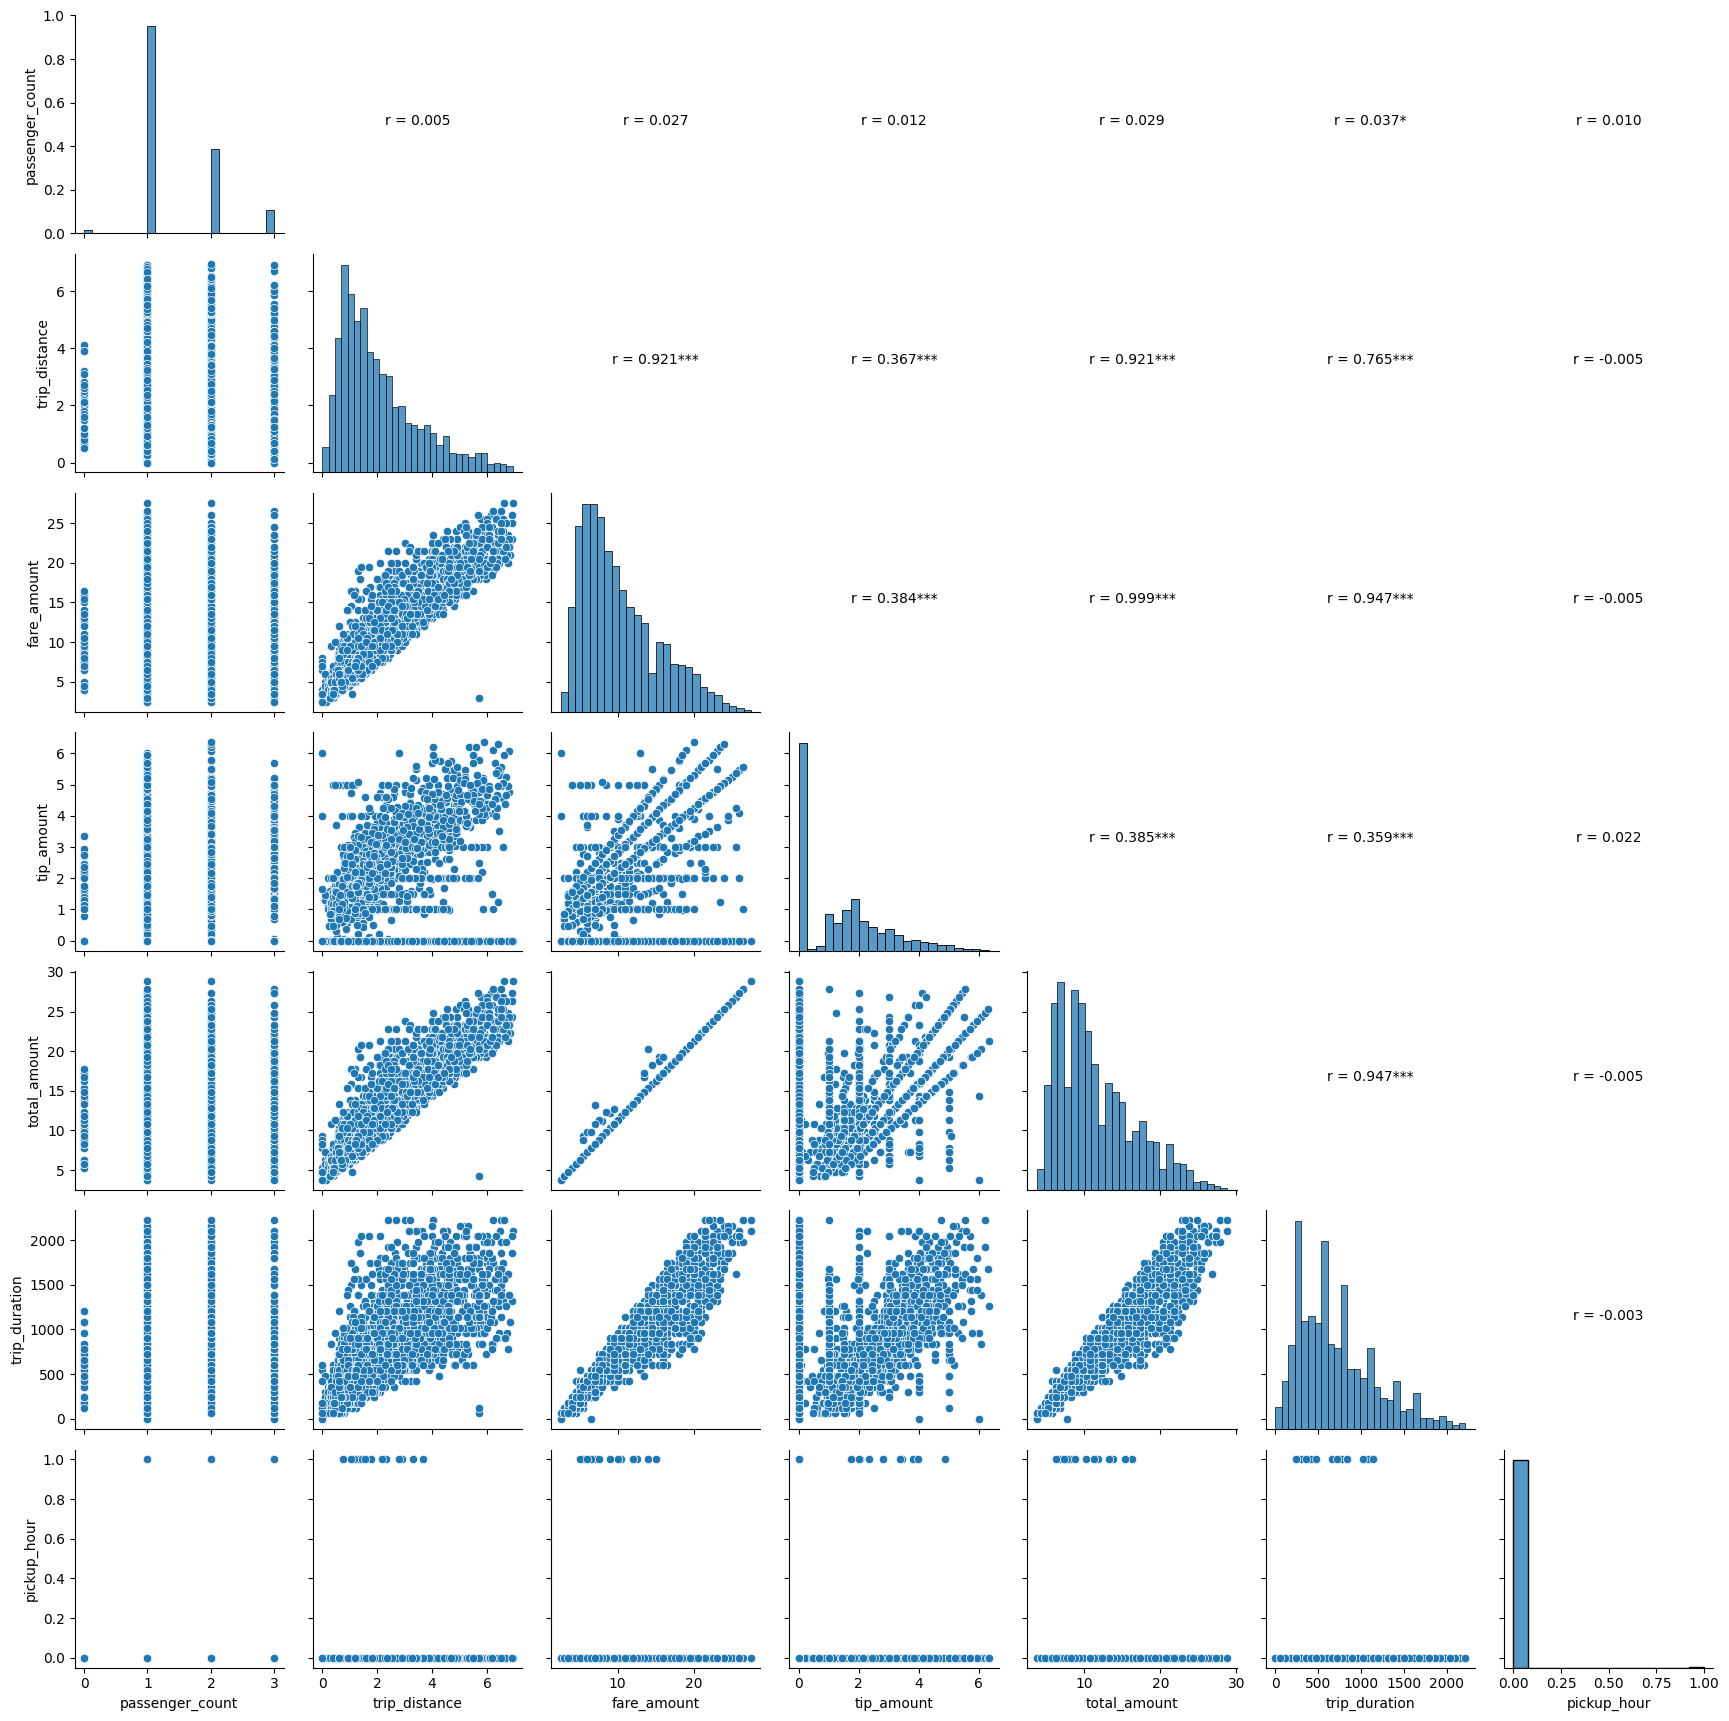

In [5]:
import scipy
# For plot size options, see: plotnine.options.figure_size = (., .)
import matplotlib.pyplot as plt
# plt.figure(figsize = (., .))
import seaborn as sns

#Note: before this I dropped NA values in dataset transformations.
def reg_coef(x, y, label=None, color=None, **kwargs):
    # A modified version of https://stackoverflow.com/a/63433499
    ax = plt.gca()
    r,p = scipy.stats.pearsonr(x, y)
    val = 'r = {:.3f}'.format(r)
    if p <= 0.001:
        val = val + "***"  
    elif p <= 0.01:
        val = val + "**"  
    elif p <= 0.05:
        val = val + "*"    
    ax.annotate(val, xy=(0.5, 0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()
g = sns.PairGrid(dt_train.iloc[:, [3,4,9,12,15,22,23]], diag_sharey = False)
tmp_plt = g.map_diag(sns.histplot)
tmp_plt = g.map_lower(sns.scatterplot)
tmp_plt = g.map_upper(reg_coef)
plt.show()

In [7]:
# mdl = smf.ols(formula = "total_amount ~ trip_distance + pickup_hour + trip_duration + fare_amount + \
#                             extra + mta_tax + tip_amount +  improvement_surcharge + \
#                              + PULocationID_encoded + DOLocationID_encoded +\
#                             RatecodeID_1 + RatecodeID_2 + RatecodeID_3 + RatecodeID_4 + RatecodeID_5 + RatecodeID_6 + RatecodeID_99 +\
#                             pickup_weekday_Monday + pickup_weekday_Tuesday + pickup_weekday_Wednesday +\
#                             pickup_weekday_Thursday + pickup_weekday_Saturday", data = dt_train)
mdl = smf.ols(formula = "total_amount ~ trip_distance + pickup_hour + trip_duration + fare_amount + \
                            extra + mta_tax + tip_amount +  improvement_surcharge + \
                             + PULocationID_encoded + DOLocationID_encoded\
                           ", data = dt_train)
mdl_summary = mdl.fit()
print(mdl_summary.summary().tables[1])



                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.8280      0.014     58.321      0.000       0.800       0.856
trip_distance             0.0179      0.011      1.637      0.102      -0.004       0.039
pickup_hour              -0.0191      0.048     -0.396      0.692      -0.114       0.075
trip_duration          5.978e-05   4.38e-05      1.365      0.172   -2.61e-05       0.000
fare_amount               0.9890      0.006    152.783      0.000       0.976       1.002
extra                     0.4140      0.007     58.321      0.000       0.400       0.428
mta_tax                   0.4140      0.007     58.321      0.000       0.400       0.428
tip_amount                0.0078      0.002      3.293      0.001       0.003       0.012
improvement_surcharge     0.2484      0.004     58.321      0.000       0.240       0.257
PULocation

In [ ]:
# import statsmodels.formula.api as smf

# # Define the initial formula for the model
# formula = "total_amount ~ trip_distance + pickup_hour + trip_duration + fare_amount + \
#                             extra + mta_tax + tip_amount +  improvement_surcharge + \
#                              + PULocationID_encoded + DOLocationID_encoded +\
#                             RatecodeID_1 + RatecodeID_2 + RatecodeID_3 + RatecodeID_4 + RatecodeID_5 + RatecodeID_6 + RatecodeID_99 +\
#                             pickup_weekday_Monday + pickup_weekday_Tuesday + pickup_weekday_Wednesday +\
#                             pickup_weekday_Thursday + pickup_weekday_Saturday"

# # Iteratively remove variables with P > 0.05
# while True:
#     # Fit the model
#     mdl = smf.ols(formula=formula, data=dt_train).fit()
    
#     # Get the summary table
#     summary_table = mdl.summary2().tables[1]
    
#     # Identify variables with P > 0.05
#     high_p_columns = summary_table[summary_table['P>|t|'] > 0.05].index.tolist()
    
#     if not high_p_columns:
#         # Stop the loop if no variables with P > 0.05 remain
#         break
    
#     # Identify the base variables (remove categorical levels properly)
#     variable_to_remove = high_p_columns[0]
    
#     # For categorical variables, find the base name (e.g., "RatecodeID" from "RatecodeID_2[T.True]")
#     base_variable = variable_to_remove.split("[")[0]
    
#     # Check if the base variable is already removed
#     if base_variable in formula:
#         # Remove the entire variable (e.g., all of "RatecodeID")
#         formula_parts = formula.split("~")
#         predictors = formula_parts[1].strip().split(" + ")
#         predictors = [p for p in predictors if base_variable not in p]
#         formula = f"{formula_parts[0]} ~ {' + '.join(predictors)}"
#         print(f"Removed: {base_variable}")
#     else:
#         print(f"Variable {base_variable} is already removed.")
    
# # Print the final formula and summary
# print("Final formula:", formula)
# print(mdl.summary())


Removed: RatecodeID_2
Removed: RatecodeID_1
Removed: RatecodeID_3
Removed: RatecodeID_4
Removed: RatecodeID_5
Removed: RatecodeID_6
Removed: pickup_weekday_Saturday
Final formula: total_amount        ~ trip_distance + pickup_hour + trip_duration + fare_amount +                             extra + mta_tax + tip_amount +  improvement_surcharge +                              + PULocationID_encoded + DOLocationID_encoded + RatecodeID_99 +                            pickup_weekday_Monday + pickup_weekday_Tuesday + pickup_weekday_Wednesday +                            pickup_weekday_Thursday
                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.273e+08
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:       

In [ ]:
# import re

# # Define the initial formula for the model
# formula = """
#     np.log(total_amount) ~ np.log(trip_distance+1) + C(pickup_hour) + np.log(trip_duration + 1) + 
#                             np.log(fare_amount + 1) + extra + mta_tax + 
#                             np.log(tip_amount + 1) + improvement_surcharge + 
#                             C(PULocationID_encoded) + C(DOLocationID_encoded)
# """

# # Iteratively remove variables with P > 0.05
# while True:
#     # Fit the model
#     mdl = smf.ols(formula=formula, data=dt_train).fit()
    
#     # Get the summary table
#     summary_table = mdl.summary2().tables[1]
    
#     # Identify variables with P > 0.05
#     high_p_columns = summary_table[summary_table['P>|t|'] > 0.05].index.tolist()
    
#     if not high_p_columns:
#         # Stop the loop if no variables with P > 0.05 remain
#         break
    
#     # Remove the first variable with high p-value
#     variable_to_remove = high_p_columns[0]
    
#     # Regex to match the variable in the formula
#     pattern = re.escape(variable_to_remove.split("[")[0])  # Handle categorical variables
#     formula_rhs = formula.split("~")[1]  # Extract predictors (right-hand side)
#     formula_rhs = re.sub(rf"\+?\s*{pattern}[^\+]*", "", formula_rhs)  # Remove the term
    
#     # Clean up the formula (remove redundant "+" signs or spaces)
#     formula_rhs = re.sub(r"\s*\+\s*", " + ", formula_rhs.strip()).strip(" +")
#     formula = f"np.log(total_amount) ~ {formula_rhs}"  # Reconstruct the formula
    
#     print(f"Removed: {variable_to_remove}")

# # Print the final formula and summary
# print("Final formula:", formula)
# print(mdl.summary())


In [14]:
import statsmodels.formula.api as smf

# Assuming `dt_train` is the dataset you're working with and `final_formula` is the final formula string after VIF filtering
final_model = smf.ols(formula=formula, data=dt_train).fit()

# Output the summary of the model
final_model_summary = final_model.summary()
print(final_model_summary)


                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.738e+07
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:53:25   Log-Likelihood:            -3.2989e+06
No. Observations:             4862749   AIC:                         6.598e+06
Df Residuals:                 4862736   BIC:                         6.598e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

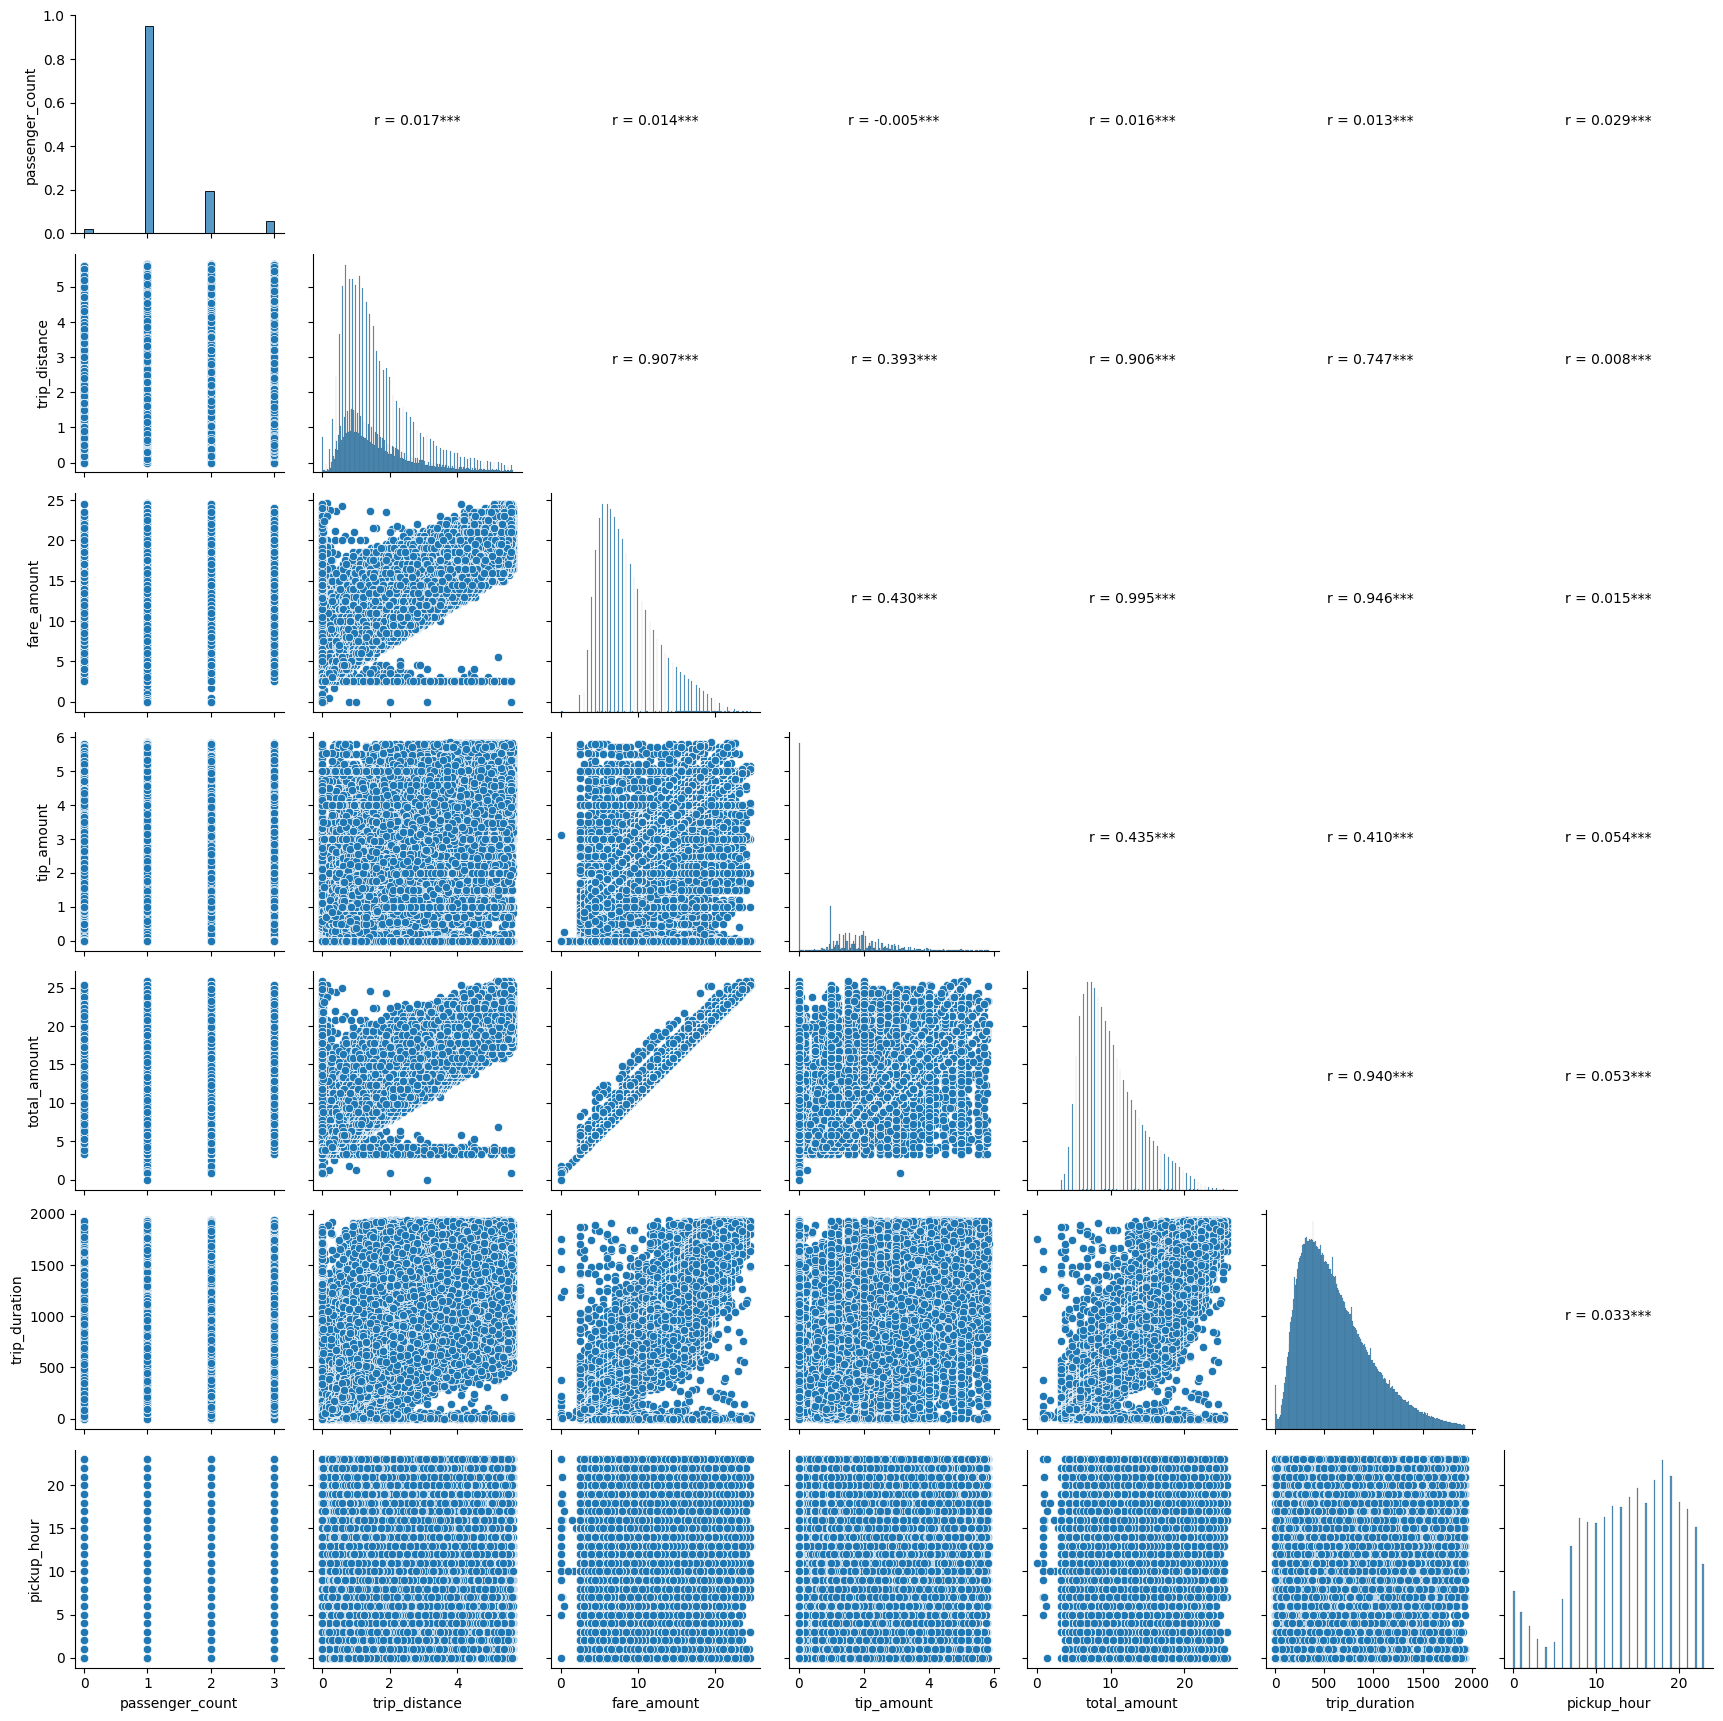

In [9]:
import scipy
# For plot size options, see: plotnine.options.figure_size = (., .)
import matplotlib.pyplot as plt
# plt.figure(figsize = (., .))
import seaborn as sns

#Note: before this I dropped NA values in dataset transformations.
def reg_coef(x, y, label=None, color=None, **kwargs):
    # A modified version of https://stackoverflow.com/a/63433499
    ax = plt.gca()
    r,p = scipy.stats.pearsonr(x, y)
    val = 'r = {:.3f}'.format(r)
    if p <= 0.001:
        val = val + "***"  
    elif p <= 0.01:
        val = val + "**"  
    elif p <= 0.05:
        val = val + "*"    
    ax.annotate(val, xy=(0.5, 0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()
g = sns.PairGrid(dt_test.iloc[:, [3,4,9,12,15,22,23]], diag_sharey = False)
tmp_plt = g.map_diag(sns.histplot)
tmp_plt = g.map_lower(sns.scatterplot)
tmp_plt = g.map_upper(reg_coef)
plt.show()